In [1]:
import h5py
import tensorflow as tf
import numpy as np
from numpy import f2py
import scipy.interpolate as interp

import matplotlib as mpl
import matplotlib.pyplot as plt
import time

import constants
import eos
import lya_fields
import snapshot

# TensorFlow

## Interpolating $n(\rho, T)$

In [2]:
filename = "../../../../../cscratch1/sd/jupiter/sim2_z3_FGPA_cgs.h5"

snap = snapshot.Snapshot(filename)

In [8]:
## load in snapshot info
a = snap.scale_factor
z = snap.z
u = snap.universe
h = u.h
omega_b = u.omega_b

eos_obj = eos.EOS_at_z(z)
mean_rhob_cgs = omega_b * h*h * constants.rho_crit_100_cgs
a3_inv = 1.0 / (a * a * a)

## create the rho, temp, and nhi arrays
length = 100 # dimension size

log10_rho = np.linspace(-1, 3, num=length)
rhob = 10**log10_rho
rhob_cgs = mean_rhob_cgs * a3_inv * rhob

log10_t = np.linspace(3, 6, num=length)
temp = 10**log10_t

nhi_grid = np.ndarray((length, length))

start = time.time()
for i in range(length):
    for j in range(length):
        nhi_grid[i, j] = eos_obj.nyx_eos(rhob_cgs[i], temp[j])

print('Duration:', time.time() - start)

Duration: 2.020350694656372


In [4]:
# interpolated function n(rho, T)
deg = 3 # degree of spline; default is 3
f_log10 = interp.RectBivariateSpline(log10_rho, log10_t, nhi, kx=deg, ky=deg)

# the interpolated partial derivatives n_[log(rho)] and n_[log(T)]
f_r_grid = f_log10(log10_rho, log10_t, dx=1, dy=0)
f_r_log10 = interp.interp2d(log10_rho, log10_t, f_r_grid)

f_t_grid = f_log10(log10_rho, log10_t, dx=0, dy=1)
f_t_log10 = interp.interp2d(log10_rho, log10_t, f_t_grid)

### Calculating $n_x$ from $n_{\log{x}}$ via Chain Rule

The below calculation shows $x = \rho$; the calculation with $T$ is essentially the same.

$$
\frac{\partial n(\log{\rho}, \log{T})}{\partial \log_{10}(\rho)}
=
\frac{\partial n}{\partial \rho} \frac{\partial \rho}{\partial \log_{10}(\rho)} + \frac{\partial n}{\partial T} \frac{\partial T}{\partial \log_{10}(\rho)}
=
\frac{\partial n}{\partial \rho} \frac{\partial \rho}{\partial \log_{10}(\rho)}
$$

$$
\implies
n_\rho = \frac{\partial n}{\partial \rho} = \frac{\partial n(\log{\rho}, \log{T})}{\partial \log_{10}(\rho)} \cdot \frac{1}{\rho \ln{10}} = \frac{n_{\log{\rho}}}{\rho \ln{10}}.
$$

In [5]:
# define the partial derivatives n_rho and n_T
# (here, we assume log_rho and log_t are the data point coordinates)
def f_rho(log_rho, log_t):
    return f_r_log10(log_rho, log_t) / 10**log_rho / np.log(10)

def f_t(log_rho, log_t):
    return f_t_log10(log_rho, log_t) / 10**log_t / np.log(10)

In [226]:
print('low rhob, low T:', nhi[0,0])
print('high rhob, low T:', nhi[99,0])
print('high rhob, high T:', nhi[99,99])
print('low rhob, high T:', nhi[0,99])
print()
print('low rhob, low T:', f_log10(log10_rho, log10_t)[0,0])
print('high rhob, low T:', f_log10(log10_rho, log10_t)[99,0])
print('high rhob, high T:', f_log10(log10_rho, log10_t)[99,99])
print('low rhob, high T:', f_log10(log10_rho, log10_t)[0,99])

# comparing f_log10 and f_x_log10 (they all range from ~1e-14 to 1e-4)
# print(np.min(f_log10(log10_rho, log10_t)))
# print(np.min(f_r_log10(log10_rho, log10_t)))
# print(np.min(f_t_log10(log10_rho, log10_t)))

# looking at the ranges of f_x
print(np.min(f_t(log10_rho, log10_t)))
print(np.max(f_t(log10_rho, log10_t)))

# check for the discontinuity in f_rho (appears with RectBivariateSpline)
#print(f_rho(log10_rho, log10_t)[97:, 20:30])

low rhob, low T: 3.727715585859389e-12
high rhob, low T: 0.0003288457287933871
high rhob, high T: 2.8365009763626884e-09
low rhob, high T: 1.2925375483321511e-14

low rhob, low T: 3.72771558585939e-12
high rhob, low T: 0.00032884572879338716
high rhob, high T: 2.8365009763626884e-09
low rhob, high T: 1.2925375483321511e-14
-2.0225440253780743e-07
-1.4336349542331395e-20


In [229]:
## plotting n_rho (un-comment this if gradient interpolations are done with RectBivariateSpline)

# v = 1e-2
# plt.imshow(f_rho(log10_rho, log10_t), 
#            vmin=-v, vmax=v, norm=mpl.colors.SymLogNorm(1e-13))

# plt.colorbar(ticks=[-v, -1e-6, -1e-10, 0, 1e-10, 1e-6, v])

### Plotting the 3 interpolated functions (and the true n_HI grid)

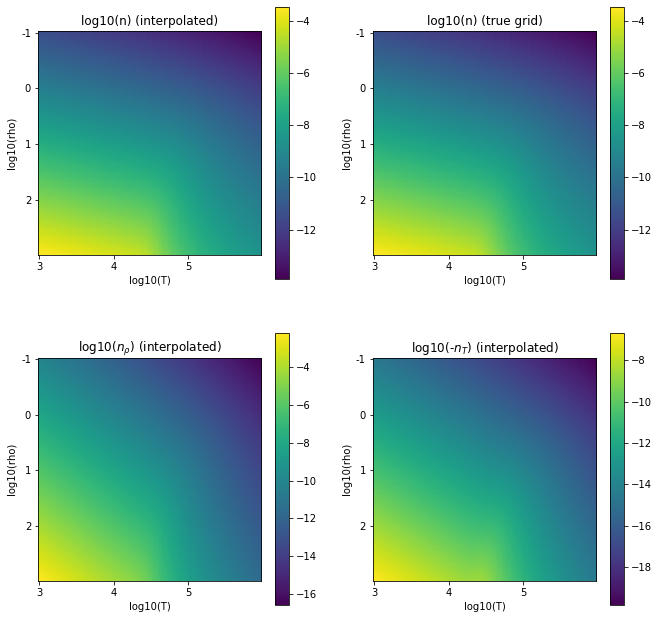

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(11,11))

## interpolated function
im1 = axes[0,0].imshow(np.log10(f_log10(log10_rho, log10_t, grid=True)))
axes[0,0].set_title("log10(n) (interpolated)")
fig.colorbar(im1, ax=axes[0,0])

axes[0,0].set_ylabel('log10(rho)')
axes[0,0].set_yticks([0, length/4, length/2, length * 3/4])
axes[0,0].set_yticklabels([-1,0,1,2])

axes[0,0].set_xlabel('log10(T)')
axes[0,0].set_xticks([0, length/3, length * 2/3])
axes[0,0].set_xticklabels([3,4,5])

## true n_HI grid
im2 = axes[0,1].imshow(np.log10(nhi))
axes[0,1].set_title("log10(n) (true grid)")
fig.colorbar(im2, ax=axes[0,1])

axes[0,1].set_ylabel('log10(rho)')
axes[0,1].set_yticks([0, length/4, length/2, length * 3/4])
axes[0,1].set_yticklabels([-1,0,1,2])

axes[0,1].set_xlabel('log10(T)')
axes[0,1].set_xticks([0, length/3, length * 2/3])
axes[0,1].set_xticklabels([3,4,5])

## interpolated partial derivative n_rho

# (un-comment this if gradient interpolations are done with RectBivariateSpline)
# v = 1e-2
# im3 = axes[1,0].imshow(f_rho(log10_rho, log10_t), 
#            vmin=-v, vmax=v, norm=mpl.colors.SymLogNorm(1e-11))
# axes[1,0].set_title(r"$n_\rho$ (interpolated)")

# cbar = fig.colorbar(im3, ax=axes[1,0])
# cbar.set_ticks([-v, -1e-6, -1e-10, 0, 1e-10, 1e-6, v])
# cbar.set_ticklabels([-v, -1e-6, -1e-10, 0, 1e-10, 1e-6, v])

im3 = axes[1,0].imshow(np.log10(f_rho(log10_rho, log10_t)))
axes[1,0].set_title(r"log10($n_\rho$) (interpolated)")
fig.colorbar(im3, ax=axes[1,0])

axes[1,0].set_ylabel('log10(rho)')
axes[1,0].set_yticks([0, length/4, length/2, length * 3/4])
axes[1,0].set_yticklabels([-1,0,1,2])

axes[1,0].set_xlabel('log10(T)')
axes[1,0].set_xticks([0, length/3, length * 2/3])
axes[1,0].set_xticklabels([3,4,5])

## interpolated partial derivative n_T
im4 = axes[1,1].imshow(np.log10(-f_t(log10_rho, log10_t)))
axes[1,1].set_title(r"log10(-$n_T$) (interpolated)")
fig.colorbar(im4, ax=axes[1,1])

axes[1,1].set_ylabel('log10(rho)')
axes[1,1].set_yticks([0, length/4, length/2, length * 3/4])
axes[1,1].set_yticklabels([-1,0,1,2])

axes[1,1].set_xlabel('log10(T)')
axes[1,1].set_xticks([0, length/3, length * 2/3])
axes[1,1].set_xticklabels([3,4,5])

plt.show()

### Feeding tensors into interpolated functions
We want to [evaluate the interp2d functions on arbitrary sets of inputs](https://stackoverflow.com/questions/47087109/evaluate-the-output-from-scipy-2d-interpolation-along-a-curve).

In [36]:
# get rho and T values from the snapshot
shape = [2,10,10]

rhob_grid = snap.read_subfield('/native_fields/baryon_density', shape)
temp_grid = snap.read_subfield('/native_fields/temperature', shape)

#nhi_tf = lya_fields.set_nhi(snap, rhob_grid, temp_grid).field

rhob_tf = rhob_grid.field
temp_tf = temp_grid.field

log10_rhob_tf = tf.math.log(rhob_tf) / np.log(10)
log10_temp_tf = tf.math.log(temp_tf) / np.log(10)

In [45]:
def flatten(t):
    '''
    Flatten a tensor t.
    
    '''
    size = tf.size(t)
    return tf.reshape(t, [size])

def unflatten(t, shape):
    '''
    Unflatten a tensor t to have a specified shape. 
    
    '''

    return tf.reshape(t, shape)

In [37]:
nhi_interp = f_log10(rhob_tf, temp_tf, grid=False)
print('nhi_interp\'s shape:', tf.shape(nhi_interp).numpy())

# force interp2d functions to do n[i,j,k] = f(x[i,j,k], y[i,j,k]); i.e.
# treat x,y as arbitrary inputs instead of coordinates
n_r_interp = interp.dfitpack.bispeu(f_r_log10.tck[0], f_r_log10.tck[1], f_r_log10.tck[2], f_r_log10.tck[3], f_r_log10.tck[4], \
                                    flatten(log10_rhob_tf), flatten(log10_temp_tf))[0]

print('n_r_interp\'s shape:', tf.shape(n_r_interp).numpy())

nhi_interp's shape: [ 2 10 10]
n_r_interp's shape: [200]


## Checking the orientation of interp2d's results

In [216]:
x = np.linspace(0, 10, num=length)
y = np.linspace(0, 10, num=length)
xs, ys = np.meshgrid(x,y)
z = 2*xs**2 + ys**2

# interpolated function n(rho, T)
z_interp = interp.interp2d(x, y, z, kind='cubic')

# the partial derivative grids
z_x_interp = z_interp(x, y, dx=1, dy=0)
z_y_interp = z_interp(x, y, dx=0, dy=1)

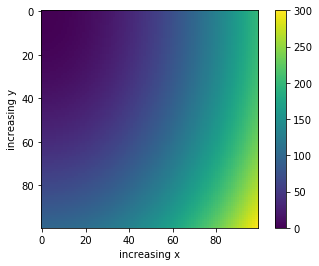

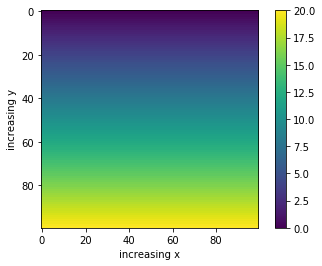

In [217]:
plt.imshow(z_interp(x,y))
plt.xlabel('increasing x')
plt.ylabel('increasing y')
plt.colorbar()
plt.show()

plt.imshow(z_y_interp)
plt.xlabel('increasing x')
plt.ylabel('increasing y')
plt.colorbar()
plt.show()

## Defining a 2-variable function and its gradients

In [3]:
@tf.custom_gradient
def bar(x, y): # f(x,y) = x * y
    def grad(upstream): # pass in the "upstream" gradient
        dz_dx = y
        dz_dy = x
        return upstream * dz_dx, upstream * dz_dy # pass grad "downstream"
    z = x * y
    return z, grad

x = tf.constant(2.0, dtype=tf.float32)
y = tf.constant(3.0, dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(y)
    z = bar(x, y)
    
print('z:', z)
print('dz/dx:', tape.gradient(z, x))
print('dz/dy:', tape.gradient(z, y))

z: tf.Tensor(6.0, shape=(), dtype=float32)
dz/dx: tf.Tensor(3.0, shape=(), dtype=float32)
dz/dy: tf.Tensor(2.0, shape=(), dtype=float32)


## Assigning an element to an existing tensor

In [7]:
x = tf.zeros([3,3,3])
#tf.tensor_scatter_nd_add?

In [6]:
skewer = tf.zeros([3])
for i in range(3):
    for j in range(3):
        x = tf.tensor_scatter_nd_add(x, [[i,j]], [skewer])
        skewer = skewer + 1
x

<tf.Tensor: shape=(3, 3, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [1., 1., 1.],
        [2., 2., 2.]],

       [[3., 3., 3.],
        [4., 4., 4.],
        [5., 5., 5.]],

       [[6., 6., 6.],
        [7., 7., 7.],
        [8., 8., 8.]]], dtype=float32)>

In [12]:
x = tf.zeros([3])
tf.tensor_scatter_nd_add(x, [[1]], [3])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 3., 0.], dtype=float32)>

## Testing speed of tensor access

It takes too long to access a tensor's entries one-by-one; I need to avoid this when I'm passing fields into the EOS or optical depth routines

In [2]:
def time_stats(duration):
    rate = duration / n**2
    print("Duration:", np.round(duration, 4))
    print("Hours needed to access 1024^3 entries:", 
      np.round(rate * 1024**3 / 3600, 4))

In [4]:
import time

n = 5
field = tf.zeros((n,n))
total = 0

start = time.time()

for i in range(n):
    for j in range(n):
        total += field[i,j]

duration = time.time() - start
time_stats(duration)

Duration: 0.0085
Hours needed to access 1024^3 entries: 101.1769


### Nested loops

In [24]:
count = 15
n = 10

start = time.time()

# outer loop
i = tf.constant(0)
condition1 = lambda i, count: tf.less(i, n)

def body1(i, r): # index i and result r
    # inner loop
    j = tf.constant(0)
    condition2 = lambda i,j,r: tf.less(j, n)
    
    def body2(i, j, r):
        r += field[i,j]
        return i, tf.add(j, 1), r
    
    i, j, r = tf.while_loop(condition2, body2, loop_vars=[i,j, r])
    
    # increment r
    return tf.add(i, 1), r

# do the loop:
r = tf.while_loop(condition1, body1, [i, count])
print(r)

duration = time.time() - start
time_stats(duration)

(<tf.Tensor: shape=(), dtype=int32, numpy=10>, <tf.Tensor: shape=(), dtype=float32, numpy=15.0>)
Duration: 0.0686
Hours needed to access 1024^3 entries: 204.7353


## Testing tf gradients

In [13]:
tf.math.pow(z, 2)

<tf.Tensor: shape=(), dtype=float32, numpy=9.0>

In [11]:
z = tf.constant(3.)
with tf.GradientTape() as tape:
    tape.watch(z) # without this line, grad is None
    a = tf.divide(1, z+1)
    print('a:', a)
    
grad = tape.gradient(a, z)
print('grad:', grad)

a: tf.Tensor(0.25, shape=(), dtype=float32)
grad: tf.Tensor(-0.0625, shape=(), dtype=float32)


# Load in the data

In [2]:
filename = "../../../../../cscratch1/sd/jupiter/sim2_z3_FGPA_cgs.h5"

#snap = h5py.File(filename,'r')

In [5]:
name = 'aux_fields'

snap.keys()

if name in snap:
    print('ok')

ok


## Testing classes

In [3]:
snap = snapshot.Snapshot(filename)

### snapshot

In [4]:
# test snapshot methods
start = time.time()

temp = snap.read_field('/native_fields/temperature')
rhob = snap.read_field('/native_fields/baryon_density')
print(temp.shape)
print(temp.size)
print('Time:', time.time() - start)

[1024 1024 1024]
[21.09375 21.09375 21.09375]
Time: 10.361153364181519


In [5]:
# test read_subfield
start = time.time()
shape = [2,3,5]

temp2 = snap.read_subfield('/native_fields/temperature', shape)
print(temp2.shape)
print(temp2.size)
print('Time:', time.time() - start)

[2, 3, 5]
tf.Tensor([0.04119873 0.0617981  0.10299683], shape=(3,), dtype=float64)
Time: 2.255763530731201


### universe

In [3]:
u = snap.universe
chi = 10
z = 1
u.chi_to_proper_cgs(chi, z)

<tf.Tensor: shape=(), dtype=float64, numpy=2.2856888888888885e+25>

In [4]:
u.h

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.675>

### eos

In [5]:
import eos

eos_obj = eos.EOS_at_z(snap.z)
# returns nhi
eos_obj.nyx_eos(rhob.field[0,0,0] * 1e-29, temp.field[0,0,0])

9.275646225472467e-13

## Look at the ranges of rhob and temp

[Count the number of elements in a tensor that are above a threshold](https://stackoverflow.com/questions/48292059/in-tensorflow-what-is-the-easiest-way-to-count-the-elements-in-a-tensor-that-ar)

In [21]:
inds = (0, slice(0, 10), slice(0, 1024))

print('max rhob in this slice:', tf.reduce_max(rhob.field[inds]).numpy())

max of this rhob slice: 80.97874


In [49]:
## oor = out-of-range
elements_oor = tf.math.less(rhob.field, 1e-2) | \
    tf.math.greater(rhob.field, 1e3)
num_elements_oor = tf.math.reduce_sum(tf.cast(elements_oor, tf.int32))
print('Percent of elements out-of-range (rhob):', 
      str((num_elements_oor / 1024**3 * 100).numpy()) + '%')

## the below code prints 0.0%
# elements_oor = tf.math.less(temp.field, 1e3) | \
#     tf.math.greater(temp.field, 1e6)
# num_elements_oor = tf.math.reduce_sum(tf.cast(elements_oor, tf.int32))
# print('Percent of elements out-of-range (temp):', 
#       str((num_elements_oor / 1024**3 * 100).numpy()) + '%')

Percent of elements out-of-range (rhob): 0.00018319115042686462%


## Metadata

In [5]:
shape = snap['domain'].attrs['shape']
size = snap['domain'].attrs['size']

z = snap['universe'].attrs['redshift']
omega_b = snap['universe'].attrs['omega_b']
omega_m = snap['universe'].attrs['omega_m']
omega_l = snap['universe'].attrs['omega_l']
h = snap['universe'].attrs['hubble']

scale_factor = 1.0 / (1.0 + z)

In [6]:
print(shape)
print(size)

[1024 1024 1024]
[21.09375 21.09375 21.09375]


In [5]:
snap.close()

## Wrapping Fortran functions to Python

[Three ways to wrap](https://numpy.org/doc/stable/f2py/f2py.getting-started.html)

- Quick way (this requires Python 3.7 and NumPy 1.18): `python3 -m numpy.f2py -c eos-t.f90 -m eos_t`


In [3]:
from platform import python_version
print(python_version())

3.7.10


In [4]:
import eos_t

In [5]:
eos_t.atomic_rates.tabulate_rates()
print(eos_t.atomic_rates.alphahp)

[1.26271073e-10 1.25558019e-10 1.24848791e-10 ... 6.57445059e-19
 6.47458444e-19 6.37622769e-19]
